In [4]:
import os

import numpy as np
import torch
from lib.config import cfg

import lib.dataset.dataset3D as dataUtils
from lib.vortex.vortex import Vortex
from lib.config.project_manager import ProjectManager

project = ProjectManager()
project.load('Test_Crop')

#project.create_new(
#    name = 'Test_Crop',
#    dataset2D_path = '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset',
#    dataset3D_path = '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset')

cfg = project.get_cfg()

320
Successfully loaded project Test_Crop!


In [5]:
training_set = dataUtils.VortexDataset3D(cfg, set='train')
val_set = dataUtils.VortexDataset3D(cfg, set='val')
calibPaths = [training_set.coco.dataset['calibration']['intrinsics'], 
              training_set.coco.dataset['calibration']['extrinsics']]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
weights = '/home/timo/Desktop/VoRTEx/projects/Test/models/vortex/Run_20210705-185157/Vortex-d_30.pth'

efficienttrack_weights = '/home/timo/Desktop/VoRTEx/projects/Test/models/efficienttrack/EfficientTrack-d3_80_171153.pth'

vortexNet = Vortex('train', cfg, calibPaths, weights, None)

projects/Test_Crop/lookup.npy
[Info] loaded weights: Vortex-d_30.pth


In [9]:
vortexNet.train(training_set, val_set, 1000)

  0%|          | 0/284 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
vortexNet = Vortex('inference', cfg, calibPaths, '/home/timo/Desktop/VoRTEx/projects/Test/models/vortex/Run_20210705-185157/Vortex-d_30.pth')

[Info] loaded weights: Vortex-d_30.pth


In [5]:
from lib.vortex.modules.efficientdet.efficientdet import EfficientDet 
efficientDet = EfficientDet('inference', cfg, '/home/timo/Desktop/VoRTEx/projects/Test_Crop/models/efficientdet/Run_20210705-215016/efficientdet-d0_50.pth')

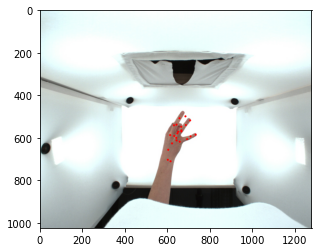

In [26]:
import cv2
import matplotlib.pyplot as plt
img_paths = [
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_T/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_RFT/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_RBT/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_LBT/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_LFT/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_RC/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_LC/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_RFB/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_RBB/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_LBB/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_LFB/Frame_10274.jpg',
    '/home/timo/Desktop/VoRTEx/datasets/Combined_Dataset/val/Colleen_03032021_Cara/Object_2/Camera_B/Frame_10274.jpg',
]

centerHMs = []
imgs = []
for img_path in img_paths:
    out_dict = efficientDet.predict_on_image(img_path)
    roi = out_dict['predictions'][0]['rois'][0]
    centerHM = np.array([int((roi[0]+roi[2])/2), int((roi[0]+roi[2])/2)])
    centerHMs.append(centerHM)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.
    bbox_hw = 160
    img = img[centerHM[1]-bbox_hw:centerHM[1]+bbox_hw, centerHM[0]-bbox_hw:centerHM[0]+bbox_hw, :]
    imgs.append(img)

imgs = torch.from_numpy(np.array(imgs))
imgs = imgs.permute(0,3,1,2).view(1,12,3,320,320).cuda()
centerHMs = np.array(centerHMs)
center3D = torch.from_numpy(val_set.reproTool.reconstructPoint(centerHMs.transpose())).cuda()
centerHMs = torch.from_numpy(centerHMs).cuda()

heatmap3D, heatmaps_padded, points3D_net = vortexNet.model(imgs, torch.unsqueeze(centerHMs,0), torch.unsqueeze(center3D, 0))
points2D = []
for point in points3D_net[0].cpu().numpy():
    points2D.append(val_set.reproTool.reprojectPoint(point))

img = cv2.cvtColor(cv2.imread(img_paths[11]), cv2.COLOR_BGR2RGB)
for point in points2D:
    cv2.circle(img, (int(point[11][0]), int(point[11][1])), 2, (255,0,0), thickness=5)
plt.imshow(img)
plt.imsave('test.png',img)
#for img_path in img_paths:
#    out_dict = efficientDet.predict_on_image(img_path)
#    print (out_dice)
#    efficientDet.visualize_prediction(out_dict)

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

figure = plt.figure()
axes = figure.gca(projection='3d')

c = ['r', 'r','r','r','b','b','b','b','g','g','g','g', 'orange', 'orange','orange','orange', 'y','y','y','y','purple', 'purple','purple']
line_idxs = [[0,1], [1,2], [2,3], [4,5], [5,6], [6,7], [8,9], [9,10], [10,11], [12,13], [13,14], [14,15], [16,17], [17,18], [18,19], [3,7], [7,11], [11,15], [3,21], [7,21],[11,22], [15,22],[21,22], [18,15], [19,22]]
points3D = points3D_net[0].cpu().numpy()
center3D = center3D.cpu()
for i, point in enumerate(points3D):
    #print ("Classic:", i, point)
    if i != 20:
        axes.scatter(point[0], point[1], point[2], color = c[i])
for line in line_idxs:
    axes.plot([points3D[line[0]][0], points3D[line[1]][0]], [points3D[line[0]][1], points3D[line[1]][1]], [points3D[line[0]][2], points3D[line[1]][2]], c = 'gray')

axes.set_xlim3d(center3D[0]-100, center3D[0]+100)
axes.set_ylim3d(center3D[1]-100, center3D[1]+100)
axes.set_zlim3d(center3D[2]-100, center3D[2]+100)
plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
#plt.gca().invert_zaxis()
        